# Transfer learning

This notebook demonstrates how to:

1. Use models from TensorFlow Hub with `tf.keras`.
1. Use an image classification model from TensorFlow Hub.
1. Do simple transfer learning to fine-tune a model for your own image classes.

## Setup

In [3]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

#%load_ext tensorboard

2023-09-11 23:56:04.547370: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-11 23:56:04.549191: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 23:56:04.592768: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 23:56:04.593693: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 23:56:05.319469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [4]:
%load_ext tensorboard

## An ImageNet classifier

Get a  classifier model pre-trained on the [ImageNet](https://en.wikipedia.org/wiki/ImageNet) benchmark dataset—no initial training required

### Download the classifier

Select a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> pre-trained model [from TensorFlow Hub](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2) and wrap it as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Any <a href="https://tfhub.dev/s?q=tf2&module-type=image-classification/" class="external">compatible image classifier model</a> from TensorFlow Hub will work here, including the examples provided in the drop-down below.

In [8]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

In [9]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

2023-09-11 23:56:28.822254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-11 23:56:28.822973: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Run it on a single image

Download a single image to try the model on:

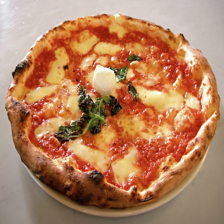

In [10]:
pizza = tf.keras.utils.get_file(fname = 'pizza.jpeg', origin = 'https://upload.wikimedia.org/wikipedia/commons/a/a3/Eq_it-na_pizza-margherita_sep2005_sml.jpg')
pizza = Image.open(pizza).resize(IMAGE_SHAPE)
pizza

In [11]:
pizza = np.array(pizza)/255.0
pizza.shape

(224, 224, 3)

Add a batch dimension (with `np.newaxis`) and pass the image to the model:

In [12]:
result = classifier.predict(pizza[np.newaxis, ...])
result.shape

1/1 [==============================] - 0s 448ms/step


(1, 1001)

The result is a 1001-element vector of logits, rating the probability of each class for the image.

The top class ID can be found with `tf.math.argmax`:

In [13]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=964>

### Decode the predictions

Take the `predicted_class` ID (such as `653`) and fetch the ImageNet dataset labels to decode the predictions:

In [14]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

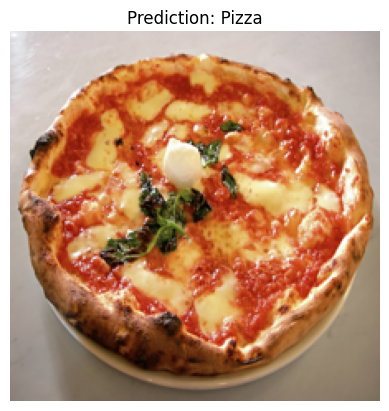

In [15]:
plt.imshow(pizza)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Simple transfer learning

But what if you want to create a custom classifier using your own dataset that has classes that aren't included in the original ImageNet dataset (that the pre-trained model was trained on)?

To do that, you can:

1. Select a pre-trained model from TensorFlow Hub; and
2. Retrain the top (last) layer to recognize the classes from your custom dataset.

### Dataset

In this example, you will use the TensorFlow flowers dataset:

In [16]:
import pathlib

data_root = pathlib.Path('../data/butterfly_dataset').with_suffix('')

First, load this data into the model using the image data off disk with `tf.keras.utils.image_dataset_from_directory`, which will generate a `tf.data.Dataset`:

In [17]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 3471 files belonging to 9 classes.
Using 2777 files for training.
Found 3471 files belonging to 9 classes.
Using 694 files for validation.


The flowers dataset has five classes:

In [18]:
class_names = np.array(train_ds.class_names)
print(class_names)

['Apatura_ilia' 'Catopsilia_pomona' 'Clossiana_euphrosyne'
 'Danaus_chrysippus' 'Gonepteryx_rhamni' 'Hebomoia_glaucippe'
 'Junonia_iphita' 'Kallima_inachus' 'Neptis_hylas']


Second, because TensorFlow Hub's convention for image models is to expect float inputs in the `[0, 1]` range, use the `tf.keras.layers.Rescaling` preprocessing layer to achieve this.

Note: You could also include the `tf.keras.layers.Rescaling` layer inside the model. Refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide for a discussion of the tradeoffs.

In [19]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

Third, finish the input pipeline by using buffered prefetching with `Dataset.prefetch`, so you can yield the data from disk without I/O blocking issues.

These are some of the most important `tf.data` methods you should use when loading data. Interested readers can learn more about them, as well as how to cache data to disk and other techniques, in the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance#prefetching) guide.

In [20]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


2023-09-11 23:56:33.691567: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Run the classifier on a batch of images

Now, run the classifier on an image batch:

In [22]:
result_batch = classifier.predict(train_ds)

87/87 [==============================] - 17s 188ms/step


In [23]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['sulphur butterfly', 'sulphur butterfly', 'sulphur butterfly', ...,
       'sulphur butterfly', 'lycaenid', 'lycaenid'], dtype='<U30')

Check how these predictions line up with the images:

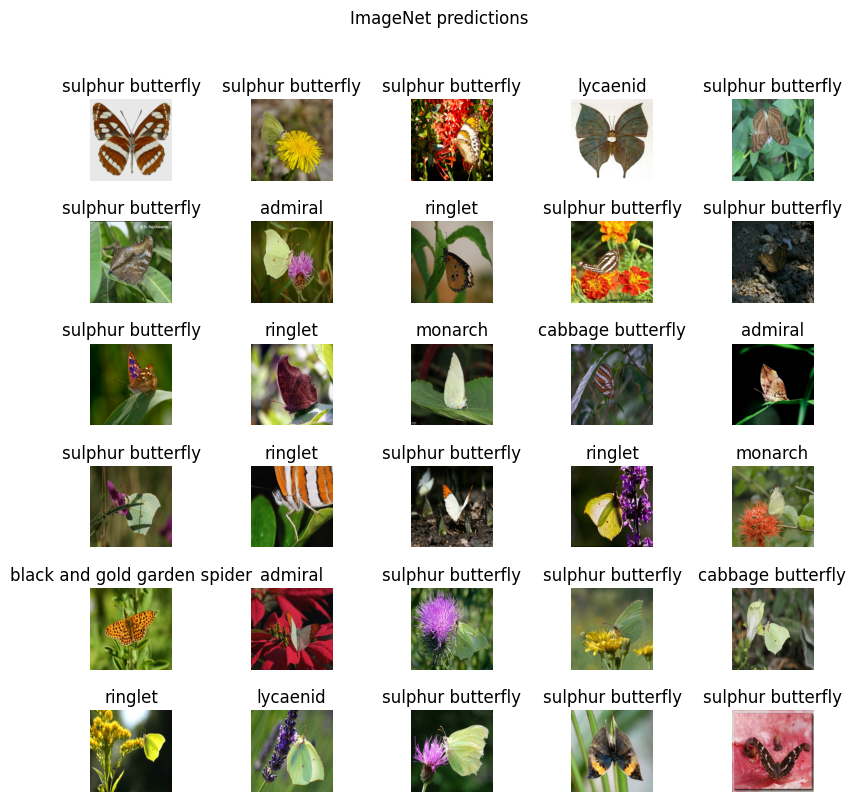

In [24]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

Note: all images are licensed CC-BY, creators are listed in the LICENSE.txt file.

The results are far from perfect, but reasonable considering that these are not the classes the model was trained for (except for "daisy").

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

Select a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> pre-trained model <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" class="external">from TensorFlow Hub</a>. Any <a href="https://tfhub.dev/s?module-type=image-feature-vector&q=tf2" class="external">compatible image feature vector model</a> from TensorFlow Hub will work here, including the examples from the drop-down menu.

In [25]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

Create the feature extractor by wrapping the pre-trained model as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Use the `trainable=False` argument to freeze the variables, so that the training only modifies the new classifier layer:

In [26]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

The feature extractor returns a 1280-long vector for each image (the image batch size remains at 32 in this example):

In [27]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


### Attach a classification head

To complete the model, wrap the feature extractor layer in a `tf.keras.Sequential` model and add a fully-connected layer for classification:

In [28]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 9)                 11529     
                                                                 
Total params: 2269513 (8.66 MB)
Trainable params: 11529 (45.04 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [29]:
predictions = model(image_batch)

In [30]:
predictions.shape

TensorShape([32, 9])

### Train the model

Use `Model.compile` to configure the training process and add a `tf.keras.callbacks.TensorBoard` callback to create and store logs:

In [31]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

Now use the `Model.fit` method to train the model.

To keep this example short, you'll be training for just 10 epochs. To visualize the training progress in TensorBoard later, create and store logs an a [TensorBoard callback](https://www.tensorflow.org/tensorboard/get_started#using_tensorboard_with_keras_modelfit).

In [32]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()
    
batch_stats_callback = CollectBatchStats()


In [33]:
NUM_EPOCHS = 10


history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=[tensorboard_callback, batch_stats_callback])

Epoch 1/10


87/87 [==============================] - 24s 248ms/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.4627 - val_acc: 0.8862
Epoch 2/10
87/87 [==============================] - 21s 243ms/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.3217 - val_acc: 0.9121
Epoch 3/10
87/87 [==============================] - 20s 236ms/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.2685 - val_acc: 0.9150
Epoch 4/10
87/87 [==============================] - 21s 240ms/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.2406 - val_acc: 0.9265
Epoch 5/10
87/87 [==============================] - 21s 240ms/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.2233 - val_acc: 0.9294
Epoch 6/10
87/87 [==============================] - 19s 223ms/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.2113 - val_acc: 0.9337
Epoch 7/10
87/87 [==============================] - 19s 214ms/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.2025 - val_acc: 0.9352
Epoch 8/10
87/87 [======

## See metrics

Start the TensorBoard to view how the metrics change with each epoch and to track other scalar values:

In [34]:
%tensorboard --logdir logs/fit

<!-- <img class="tfo-display-only-on-site" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/images/tensorboard_transfer_learning_with_hub.png?raw=1"/> -->

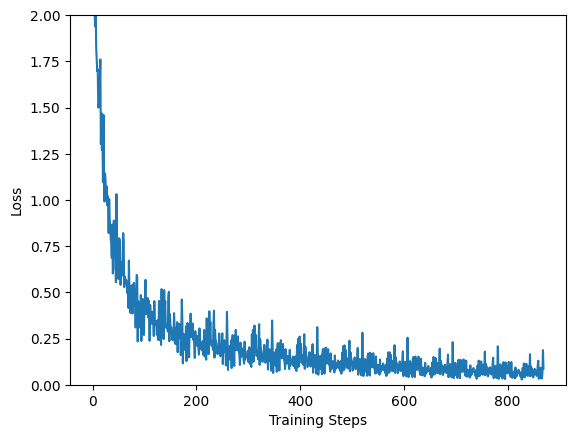

In [35]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

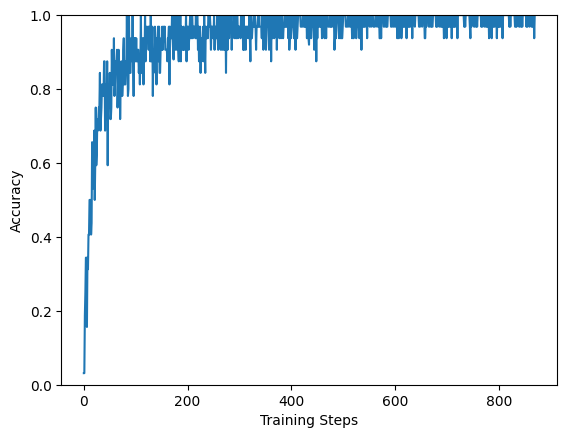

In [36]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Check the predictions

Obtain the ordered list of class names from the model predictions:

In [37]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 1s 577ms/step
['Neptis_hylas' 'Gonepteryx_rhamni' 'Hebomoia_glaucippe' 'Kallima_inachus'
 'Junonia_iphita' 'Junonia_iphita' 'Gonepteryx_rhamni' 'Danaus_chrysippus'
 'Neptis_hylas' 'Junonia_iphita' 'Apatura_ilia' 'Junonia_iphita'
 'Catopsilia_pomona' 'Neptis_hylas' 'Kallima_inachus' 'Gonepteryx_rhamni'
 'Neptis_hylas' 'Hebomoia_glaucippe' 'Gonepteryx_rhamni'
 'Catopsilia_pomona' 'Clossiana_euphrosyne' 'Hebomoia_glaucippe'
 'Gonepteryx_rhamni' 'Gonepteryx_rhamni' 'Gonepteryx_rhamni'
 'Catopsilia_pomona' 'Gonepteryx_rhamni' 'Gonepteryx_rhamni'
 'Kallima_inachus' 'Apatura_ilia' 'Apatura_ilia' 'Apatura_ilia']


Plot the model predictions:

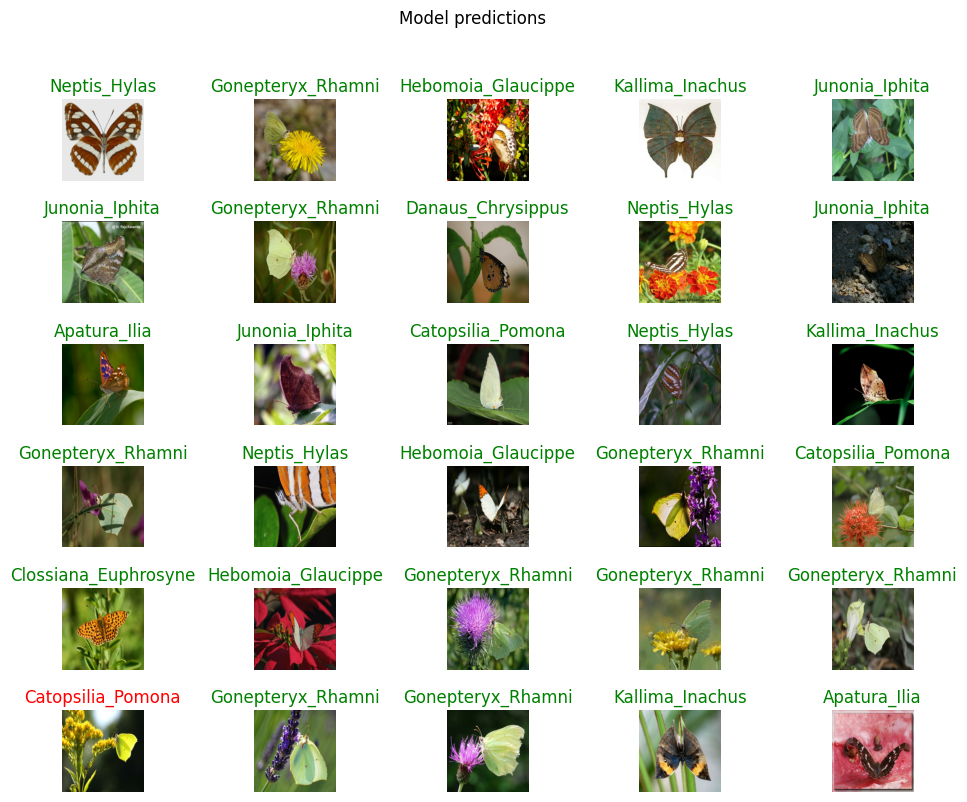

In [38]:
fig = plt.figure(figsize=(12,9))
plt.subplots_adjust(hspace=0.5)

correct_labels = [int(predicted_id[x]) == int(labels_batch[x]) for x in range(len(predicted_id[:30]))]

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  if correct_labels[n]:
    plt.title(predicted_label_batch[n].title(), color='g')
  else:
    plt.title(predicted_label_batch[n].title(), color='r')

  plt.axis('off')
_ = plt.suptitle("Model predictions")

# Make a confusion matrix

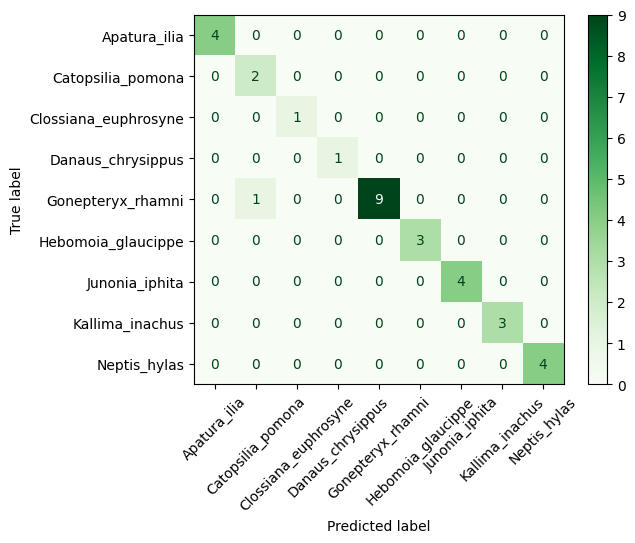

In [53]:
from sklearn import metrics

# Create the confusion matrix
confusion_matrix = metrics.confusion_matrix(labels_batch, predicted_id)

#confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = class_names)

cm_display.plot(cmap=plt.cm.Greens, xticks_rotation=45)
plt.show()

## Export and reload your model

Now that you've trained the model, export it as a SavedModel for reusing it later.

In [54]:
t = time.time()

export_path = "saved_models/{}".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: saved_models/1694469877/assets


INFO:tensorflow:Assets written to: saved_models/1694469877/assets


'saved_models/1694469877'

Confirm that you can reload the SavedModel and that the model is able to output the same results:

In [55]:
reloaded = tf.keras.models.load_model(export_path)

In [56]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

1/1 [==============================] - 1s 515ms/step


In [57]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [106]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

['Neptis_hylas' 'Gonepteryx_rhamni' 'Hebomoia_glaucippe' 'Kallima_inachus'
 'Junonia_iphita' 'Junonia_iphita' 'Gonepteryx_rhamni' 'Danaus_chrysippus'
 'Neptis_hylas' 'Junonia_iphita' 'Apatura_ilia' 'Junonia_iphita'
 'Catopsilia_pomona' 'Neptis_hylas' 'Kallima_inachus' 'Gonepteryx_rhamni'
 'Neptis_hylas' 'Hebomoia_glaucippe' 'Gonepteryx_rhamni'
 'Gonepteryx_rhamni' 'Clossiana_euphrosyne' 'Hebomoia_glaucippe'
 'Gonepteryx_rhamni' 'Gonepteryx_rhamni' 'Gonepteryx_rhamni'
 'Gonepteryx_rhamni' 'Gonepteryx_rhamni' 'Gonepteryx_rhamni'
 'Kallima_inachus' 'Apatura_ilia' 'Apatura_ilia' 'Apatura_ilia']


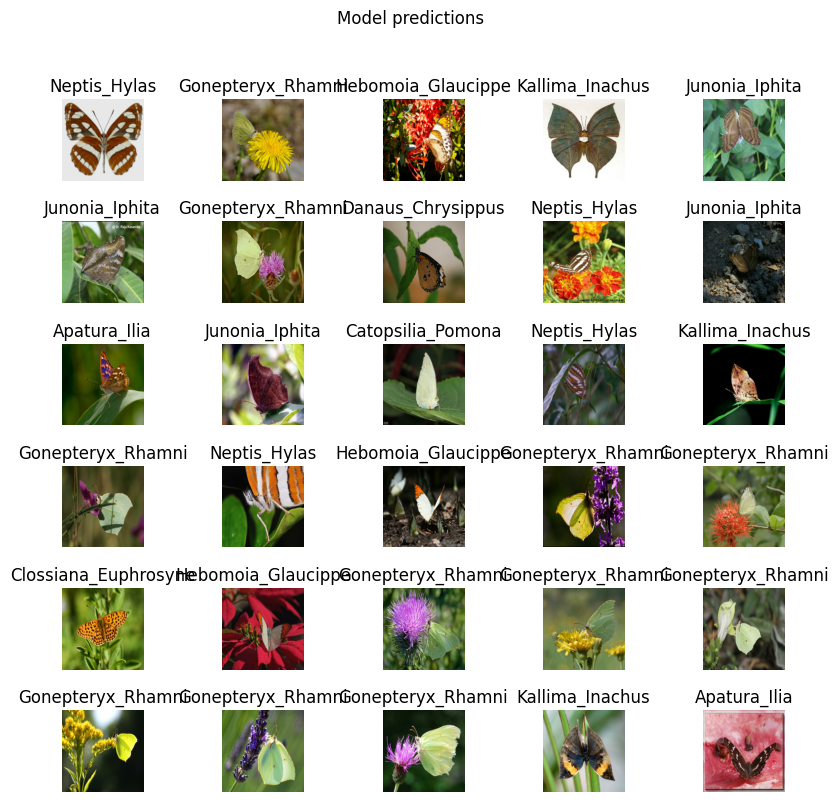

In [107]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")